In [8]:
import os
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from google.colab import drive
import scipy.io


In [9]:
# ドライブのマウント
drive.mount('/content/drive')

# フォルダパス設定
data_dir = '/content/drive/MyDrive/Lyon_decimation_128'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
### データセットの準備
features = []
labels = []


### ファイルを読み込む
for file_name in os.listdir(data_dir):
    if file_name.endswith(".mat"):
        # ファイル名からラベルを取得
        label = int(file_name.split('_')[-1][1:-4])  # 'd〇' の〇を取得

        # ファイルを読み込む
        mat = scipy.io.loadmat(os.path.join(data_dir, file_name))
        spec = mat['spec']  # コクリアグラムデータ

        # 特徴量とラベルを追加
        features.append(spec)
        labels.append(label)


### データの調整　最大時間長を持つデータに０パディングで合わせる
# 最大時間長を取得
max_len = max(spec.shape[1] for spec in features)

# ゼロパディングして特徴量を統一
padded_features = np.array([
    np.pad(spec, ((0, 0), (0, max_len - spec.shape[1])), mode='constant')
    for spec in features
])

# ラベルはそのままNumPy配列に変換
labels = np.array(labels)

# 確認用
print("パディング後の特徴量形状:", padded_features.shape)
print("ラベル形状:", labels.shape)


パディング後の特徴量形状: (500, 77, 130)
ラベル形状: (500,)


In [11]:
### データセットの作成
dataset = torch.utils.data.TensorDataset(
    torch.tensor(padded_features, dtype=torch.float32),
    torch.tensor(labels, dtype=torch.long)
)

# 訓練データと検証データの割合
train_size = int(0.7 * len(dataset))  # 訓練データ80%
val_size = len(dataset) - train_size  # 検証データ20%

# データセットを訓練用と検証用にランダムに分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaderを作成
batch_size = 32  # バッチサイズの設定

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 訓練データと検証データの確認
for batch_features, batch_labels in train_loader:
    print("訓練バッチの特徴量形状:", batch_features.shape)
    print("訓練バッチのラベル形状:", batch_labels.shape)
    print("訓練データ数", len(train_dataset))
    break

for batch_features, batch_labels in val_loader:
    print("検証バッチの特徴量形状:", batch_features.shape)
    print("検証バッチのラベル形状:", batch_labels.shape)
    print("検証データ数", len(val_dataset))
    break

訓練バッチの特徴量形状: torch.Size([32, 77, 130])
訓練バッチのラベル形状: torch.Size([32])
訓練データ数 350
検証バッチの特徴量形状: torch.Size([32, 77, 130])
検証バッチのラベル形状: torch.Size([32])
検証データ数 150


**以下より学習モデル**

In [12]:
# 恒等写像
def identity(x):
    return x # pytorchのテンソルをそのまま処理可能


# 入力層
class Input(nn.Module):
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        super(Input, self).__init__()
        # 一様分布に従う乱数
        torch.manual_seed(seed)
        self.Win = nn.Parameter(torch.empty((N_u, N_x)).uniform_(-input_scale, input_scale))
        self.Win.requires_grad = False  # 勾配更新を不要にする

    def get_weight_matrix(self):
        # 入力行列Winを返す
        return self.Win

In [13]:
class Reservoir(nn.Module):
    def __init__(self, N_x, density, rho, activation_func,  seed):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数 (torch.nn.functional)
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        super(Reservoir, self).__init__()
        self.seed = seed
        self.N_x = N_x
        self.W = self.make_connection_pytorch(N_x, density, rho, seed)
        self.W = nn.Parameter(self.W)  # Wをnn.Parameterとしてラップ
        self.x = torch.zeros(N_x, dtype=torch.float32)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.W.requires_grad = False  # リザバーの重みは訓練しない

    @staticmethod
    def make_connection_pytorch(N_x, density, rho, seed):
        torch.manual_seed(seed)

        # ランダムな接続行列の生成
        connection = torch.bernoulli(torch.full((N_x, N_x), density))
        rec_scale = 1.0
        W = connection * (torch.rand((N_x, N_x)) * 2 * rec_scale - rec_scale)

        # Wが空でないことを確認
        if W.numel() == 0:
            raise ValueError("Weight matrix W is empty. Please check the matrix generation process.")

        # スペクトル半径を計算
        eigenvalues = torch.linalg.eigvals(W)
        if eigenvalues.numel() == 0:
            raise ValueError("Eigenvalues are empty. Check the matrix W.")

        sp_radius = torch.max(torch.abs(eigenvalues.real))

        # スペクトル半径をrhoにスケーリング
        W *= rho / sp_radius

        return W

    def get_weight_matrix_W(self):
        # 重み行列Wを返す
        return self.W




In [14]:
class Output(nn.Module):
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        super(Output, self).__init__()
        # 正規分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wout = nn.Parameter(torch.randn( N_x, N_y, dtype=torch.float32))
        self.Wout.requires_grad = True


    def get_weight_matrix_wout(self):
        # 出力行列Woutを返す
        return self.Wout


    def setweight(self, Wout_opt):
        '''
        学習済みの出力結合重み行列を設定
        param Wout_opt: 新しい重み行列 (torch.Tensor)
        '''
        if not isinstance(Wout_opt, torch.Tensor):
            raise ValueError("Wout_opt must be a torch.Tensor.")
        self.Wout = Wout_opt


In [15]:
# 未修正
class Feedback:
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数で初期化
        torch.manual_seed(seed)
        self.Wfb = (torch.rand(N_x, N_y, dtype=torch.float32) * 2 * fb_scale - fb_scale)

    def __call__(self, y):
        '''
        param y: N_y次元のベクトル (torch.Tensor)
        return: N_x次元のベクトル (torch.Tensor)
        '''
        return torch.matmul(self.Wfb, y)


In [16]:
class ESN(nn.Module):
    def __init__(self, N_u, N_y, N_x, density=0.05, input_scale=1.0e+4, rho=0.95, activation_func=torch.tanh, fb_scale=None, fb_seed=0, noise_level=None, leaking_rate=0.7, output_func=None, classification=False, average_window=None, seed = 40):
        super(ESN, self).__init__()

        # モジュールの初期化
        self.Input = Input(N_u, N_x, input_scale)  # 入力層
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, seed) # リザバー層
        self.x_res = torch.zeros(N_x, dtype=torch.float32)  # リザバー状態ベクトルの初期化
        self.Output = Output(N_x, N_y) # リードアウトを取得


        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.activation_func = activation_func
        self.output_func = output_func if output_func is not None else lambda x: x
        self.classification = classification
        self.alpha = leaking_rate
        self.Input.requires_grad = False
        self.Reservoir.requires_grad = False

        # 出力層からのリザバーへのフィードバックの有無
        if fb_scale is None:
            self.Feedback = None
        else:
            self.Feedback = Feedback(N_y, N_x, fb_scale, fb_seed)

        # リザバーの状態更新にノイズを加えるか
        if noise_level is None:
            self.noise = None
        else:
            self.noise = torch.rand(N_x, 1) * noise_level * 2 - noise_level  # -noise_level to +noise_level

        # 分類問題の場合の設定
        if classification:
            if average_window is None:
                raise ValueError('Window for time average is not given!')
            else:
                self.window = torch.zeros((average_window, self.N_x))

        # リザバー状態の初期化
        self.reset_reservoir_state()

    def forward(self, u):
        '''
        param u: N_u次元のベクトル (torch.Tensor)
        return: N_y次元のベクトル (torch.Tensor)

        '''

        # 入力層の行列Winを取得
        Win = self.Input.get_weight_matrix()

        # 順伝播：入力uとWinを掛け算して、リザバー状態を更新
        x_in = torch.matmul(u, Win)

        # リザバーの行列Wを取得
        W = self.Reservoir.get_weight_matrix_W()


        # 順伝播：
        x_res =  (1.0 - self.alpha) * self.x_res + self.alpha * self.activation_func(torch.matmul(W, self.x_res) + x_in)

        # リードアウトの行列Woutを取得
        Wout = self.Output.get_weight_matrix_wout()
        #print("Wout requires_grad:", Wout.requires_grad)

        #print(Wout)
        # 順伝播：
        y = torch.matmul(x_res, Wout)



        # フィードバックがある場合の処理
        if self.Feedback is not None:
            self.x += self.Feedback(self.x)

        # ノイズの追加
        if self.noise is not None:
            self.x += self.noise

        # 学習前のモデル出力

        return y

    def reset_reservoir_state(self):
        '''リザバー状態ベクトルの初期化'''
        self.x = torch.zeros(self.N_x)

Epoch [1/150], Loss: 3.5647
Train Accuracy: 0.0800
Validation Loss: 2.7286
Validation Accuracy: 0.0533
Epoch [2/150], Loss: 2.5736
Train Accuracy: 0.0971
Validation Loss: 2.3900
Validation Accuracy: 0.1000
Epoch [3/150], Loss: 2.3144
Train Accuracy: 0.1943
Validation Loss: 2.1615
Validation Accuracy: 0.2000
Epoch [4/150], Loss: 2.0741
Train Accuracy: 0.2686
Validation Loss: 1.9462
Validation Accuracy: 0.2867
Epoch [5/150], Loss: 1.8900
Train Accuracy: 0.3429
Validation Loss: 1.7994
Validation Accuracy: 0.3600
Epoch [6/150], Loss: 1.7341
Train Accuracy: 0.4000
Validation Loss: 1.6464
Validation Accuracy: 0.4200
Epoch [7/150], Loss: 1.5873
Train Accuracy: 0.4829
Validation Loss: 1.5272
Validation Accuracy: 0.4667
Epoch [8/150], Loss: 1.4545
Train Accuracy: 0.5571
Validation Loss: 1.4090
Validation Accuracy: 0.5800
Epoch [9/150], Loss: 1.3499
Train Accuracy: 0.5943
Validation Loss: 1.3116
Validation Accuracy: 0.6000
Epoch [10/150], Loss: 1.2458
Train Accuracy: 0.6229
Validation Loss: 1.22

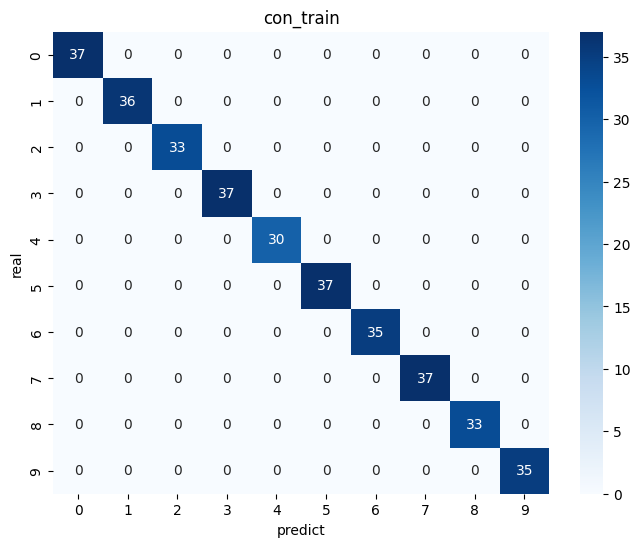

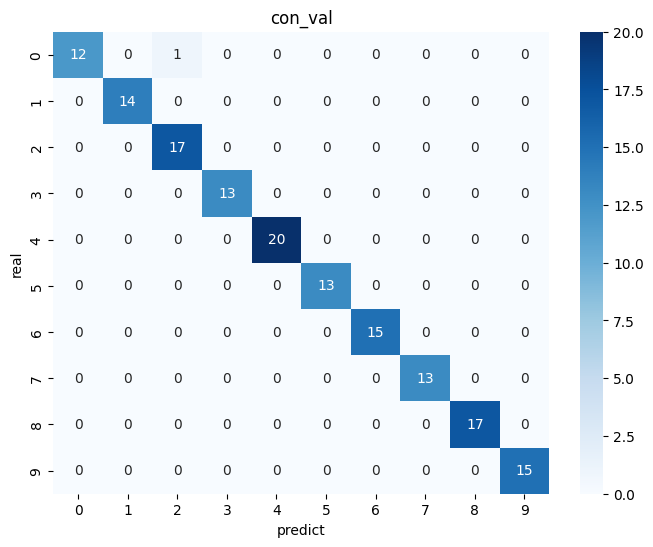

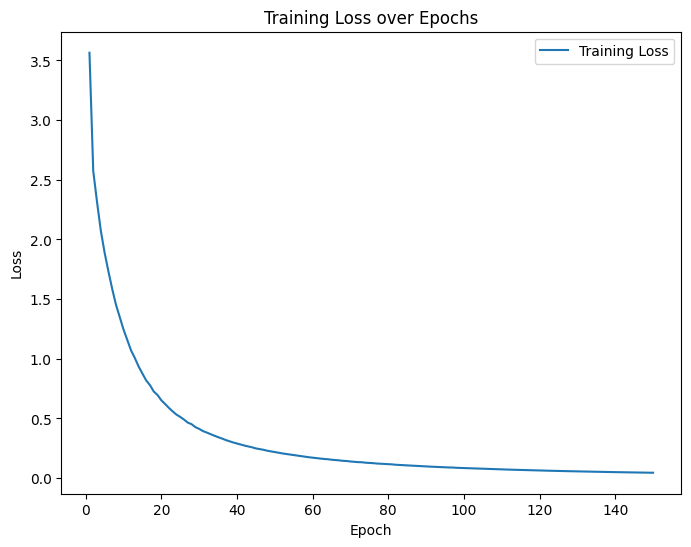

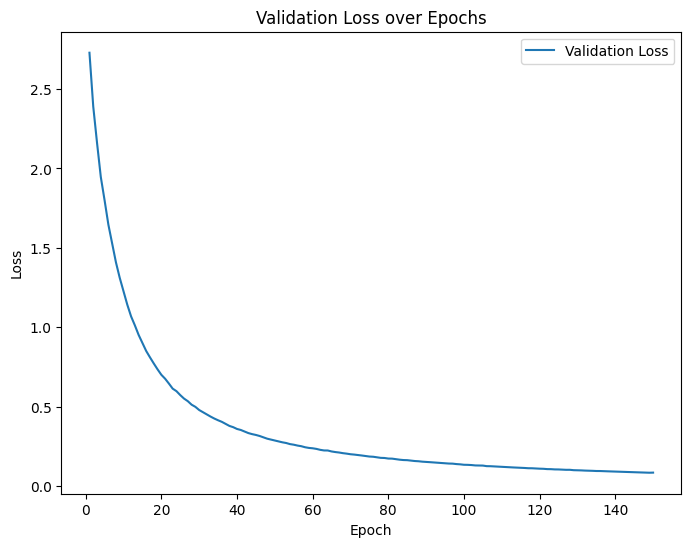

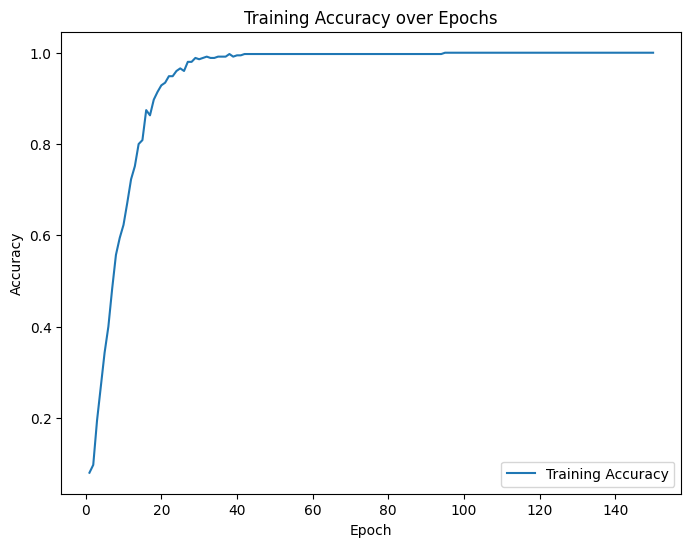

Text(0.5, 1.0, 'Validation Accuracy over Epochs')

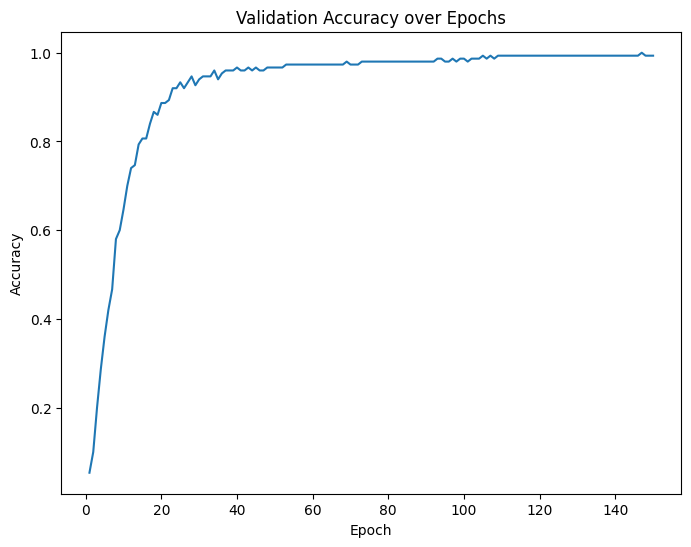

In [17]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score

# モデルのインスタンス化
N_u = 77  # 入力次元数 (77, 130 の形状から77)
N_y = len(np.unique(labels))  # クラス数
N_x = 100  # リザバーのサイズ (例として200に設定)

model = ESN(N_u=N_u, N_y=N_y, N_x=N_x)

# 最適化器と損失関数の設定
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 損失を記録するリスト
train_losses = []
val_losses = []

# 精度を記録するリスト
train_accuracies = []
val_accuracies = []

# 訓練ループ
num_epochs = 150
for epoch in range(num_epochs):
    model.train()  # 訓練モード
    train_outputs = [] # 混同行列用
    train_labels = [] # 混同行列用
    running_loss = 0.0

    # 訓練データをバッチごとに処理
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.permute(0, 2, 1)  # 軸を入れ替える
        optimizer.zero_grad()

        # 順伝播
        outputs = model(batch_features)

        # 順伝播時に出力形状を確認
        outputs = model(batch_features)
        # 各チャネルに対して最も確率が高いクラスを選択
        outputs = torch.mean(outputs, dim=1)

        # 損失計算
        loss = criterion(outputs, batch_labels)

        # バックプロパゲーション
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_outputs.extend(torch.argmax(outputs, dim=1).tolist())
        train_labels.extend(batch_labels.tolist())

    # エポック毎の平均損失を表示
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    trin_accuracy = accuracy_score(train_labels, train_outputs)
    print(f"Train Accuracy: {trin_accuracy:.4f}")
    train_accuracies.append(trin_accuracy)

    # 検証
    model.eval()  # 評価モード
    val_outputs = []
    val_labels = []
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            # 順伝播
            batch_features = batch_features.permute(0, 2, 1)  # 軸を入れ替える
            outputs = model(batch_features)
            outputs = torch.mean(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            val_outputs.extend(predicted.numpy())
            val_labels.extend(batch_labels.numpy())

            loss = criterion(outputs, batch_labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")


    val_accuracy = accuracy_score(val_labels, val_outputs)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    val_accuracies.append(val_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# 混同行列を計算
cm = confusion_matrix(val_labels, val_outputs)

# 訓練データに対する混同行列
cm_train = confusion_matrix(train_labels, train_outputs)

# 訓練データの混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('predict')
plt.ylabel('real')
plt.title('con_train')
plt.show()

# 混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('predict')
plt.ylabel('real')
plt.title('con_val')
plt.show()


# 訓練損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 検証損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# 訓練制度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

# 検証制度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')

Epoch [1/150], Loss: 9.5577
Train Accuracy: 0.1229
Validation Loss: 6.1461
Validation Accuracy: 0.1200
Epoch [2/150], Loss: 4.7171
Train Accuracy: 0.1457
Validation Loss: 3.4851
Validation Accuracy: 0.1467
Epoch [3/150], Loss: 3.3523
Train Accuracy: 0.1571
Validation Loss: 3.0231
Validation Accuracy: 0.2000
Epoch [4/150], Loss: 2.5865
Train Accuracy: 0.2400
Validation Loss: 2.5885
Validation Accuracy: 0.2667
Epoch [5/150], Loss: 2.2218
Train Accuracy: 0.2857
Validation Loss: 2.2830
Validation Accuracy: 0.3333
Epoch [6/150], Loss: 2.0032
Train Accuracy: 0.3400
Validation Loss: 2.1597
Validation Accuracy: 0.3333
Epoch [7/150], Loss: 1.8313
Train Accuracy: 0.3657
Validation Loss: 2.0622
Validation Accuracy: 0.3333
Epoch [8/150], Loss: 1.7378
Train Accuracy: 0.4200
Validation Loss: 1.9811
Validation Accuracy: 0.3800
Epoch [9/150], Loss: 1.6399
Train Accuracy: 0.4600
Validation Loss: 1.8834
Validation Accuracy: 0.3800
Epoch [10/150], Loss: 1.5656
Train Accuracy: 0.4343
Validation Loss: 1.80

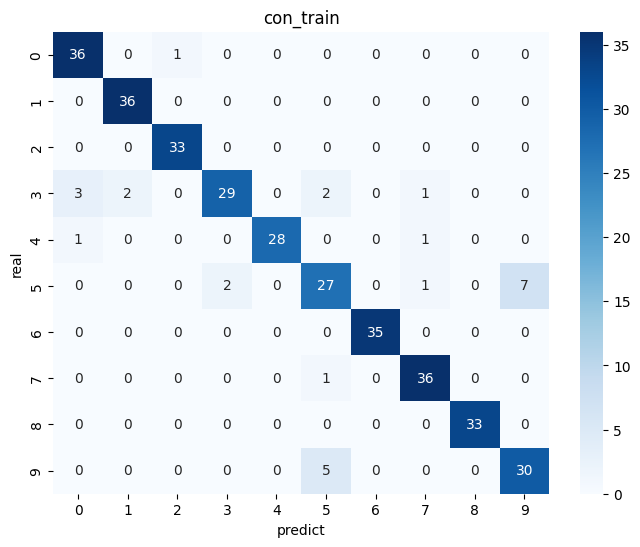

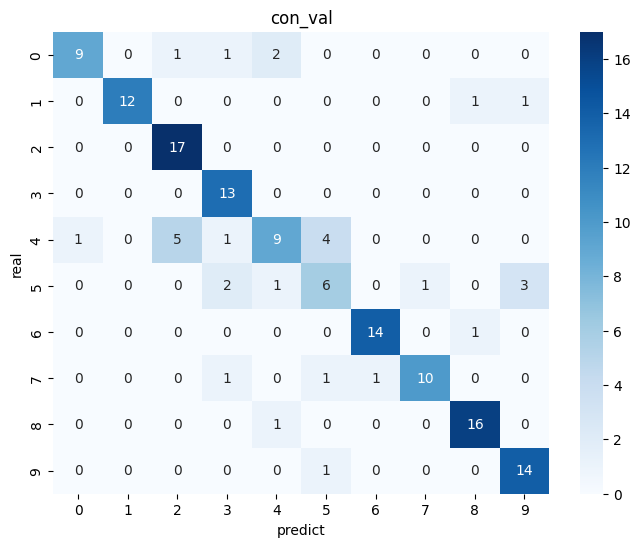

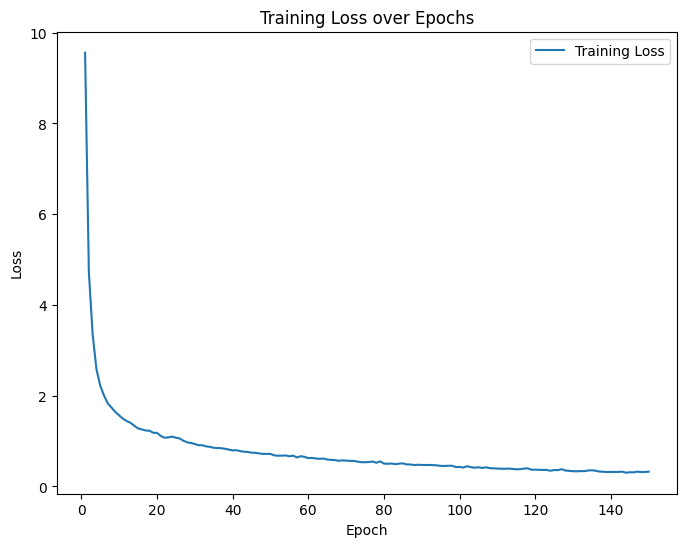

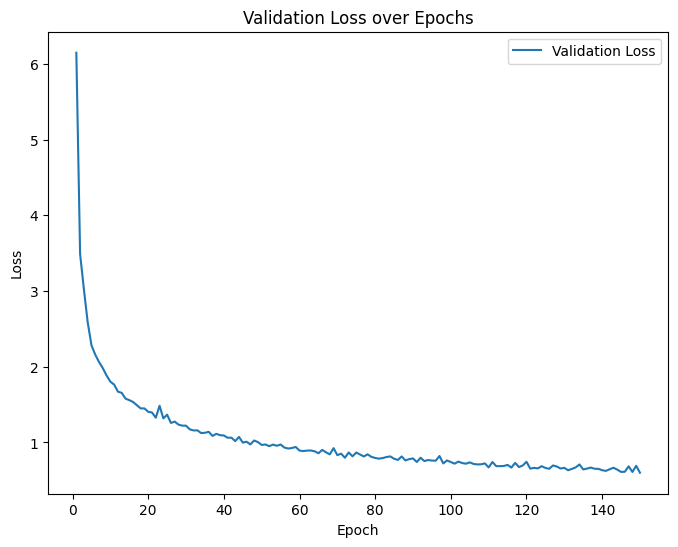

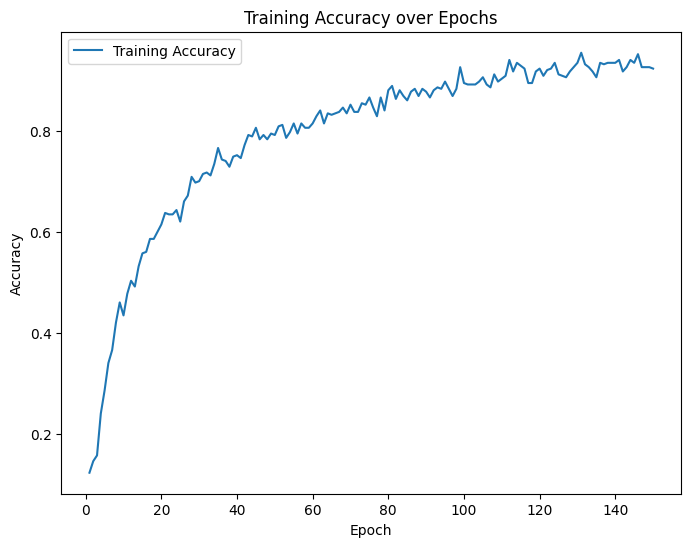

Text(0.5, 1.0, 'Validation Accuracy over Epochs')

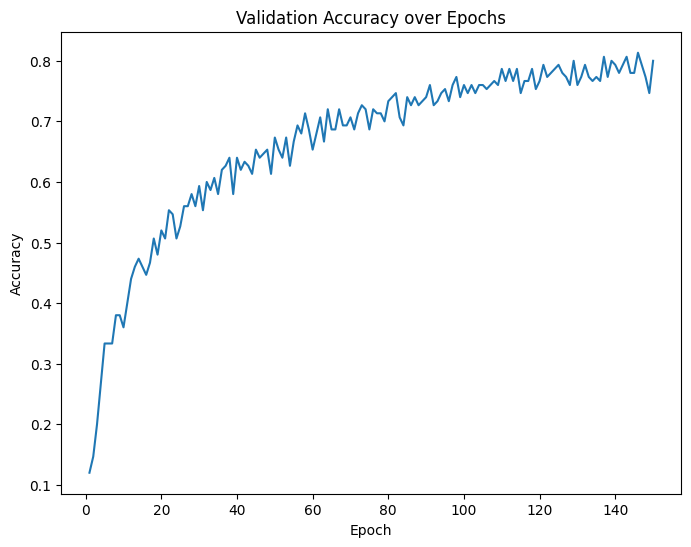

In [18]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score

# モデルのインスタンス化
N_u = 130  # 入力次元数 (77, 130 の形状から130)
N_y = len(np.unique(labels))  # クラス数
N_x = 200  # リザバーのサイズ (例として200に設定)

model = ESN(N_u=N_u, N_y=N_y, N_x=N_x)

# 最適化器と損失関数の設定
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 損失を記録するリスト
train_losses = []
val_losses = []

# 精度を記録するリスト
train_accuracies = []
val_accuracies = []

# 訓練ループ
num_epochs = 150
for epoch in range(num_epochs):
    model.train()  # 訓練モード
    train_outputs = [] # 混同行列用
    train_labels = [] # 混同行列用
    running_loss = 0.0

    # 訓練データをバッチごとに処理
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()

        # 順伝播
        outputs = model(batch_features)

        # 順伝播時に出力形状を確認
        outputs = model(batch_features)
        # 各チャネルに対して最も確率が高いクラスを選択
        outputs = torch.mean(outputs, dim=1)

        # 損失計算
        loss = criterion(outputs, batch_labels)

        # バックプロパゲーション
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_outputs.extend(torch.argmax(outputs, dim=1).tolist())
        train_labels.extend(batch_labels.tolist())

    # エポック毎の平均損失を表示
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    trin_accuracy = accuracy_score(train_labels, train_outputs)
    print(f"Train Accuracy: {trin_accuracy:.4f}")
    train_accuracies.append(trin_accuracy)

    # 検証
    model.eval()  # 評価モード
    val_outputs = []
    val_labels = []
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            # 順伝播
            outputs = model(batch_features)
            outputs = torch.mean(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            val_outputs.extend(predicted.numpy())
            val_labels.extend(batch_labels.numpy())

            loss = criterion(outputs, batch_labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")


    val_accuracy = accuracy_score(val_labels, val_outputs)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    val_accuracies.append(val_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# 混同行列を計算
cm = confusion_matrix(val_labels, val_outputs)

# 訓練データに対する混同行列
cm_train = confusion_matrix(train_labels, train_outputs)

# 訓練データの混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('predict')
plt.ylabel('real')
plt.title('con_train')
plt.show()

# 混同行列を描画
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('predict')
plt.ylabel('real')
plt.title('con_val')
plt.show()


# 訓練損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 検証損失
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()

# 訓練制度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

# 検証制度
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')